<ipython-input-39-196f51a6bd8e>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data.index = pd.date_range(start='1961-01', periods=len(data), freq='M')


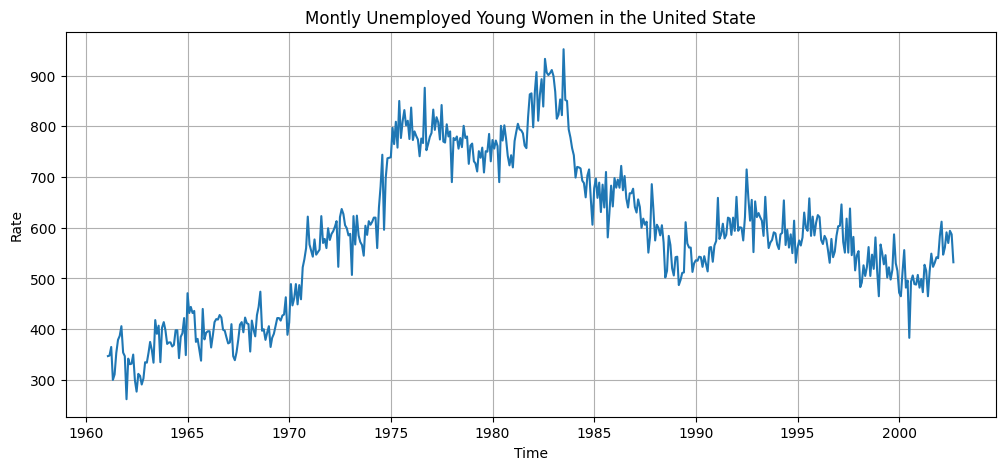

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ubah ke format time series
data = pd.read_excel('data1.xlsx')
data.index = pd.date_range(start='1961-01', periods=len(data), freq='M')

# Plot data asli
plt.figure(figsize=(12, 5))
plt.plot(data)
plt.title("Montly Unemployed Young Women in the United State")
plt.xlabel("Time")
plt.ylabel("Rate")
plt.grid(True)
plt.show()






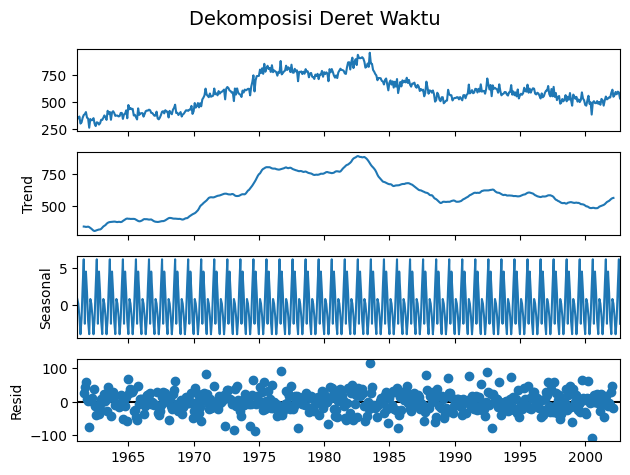

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Gunakan dekomposisi aditif (bisa juga 'multiplicative' jika pola musiman proporsional)
decompose_result = seasonal_decompose(data, model='additive', period=12)

# Plot hasil dekomposisi
decompose_result.plot()
plt.suptitle("Dekomposisi Deret Waktu", fontsize=14)
plt.tight_layout()
plt.show()

ADF Statistic: -2.043934037790816
p-value: 0.26764778182632143


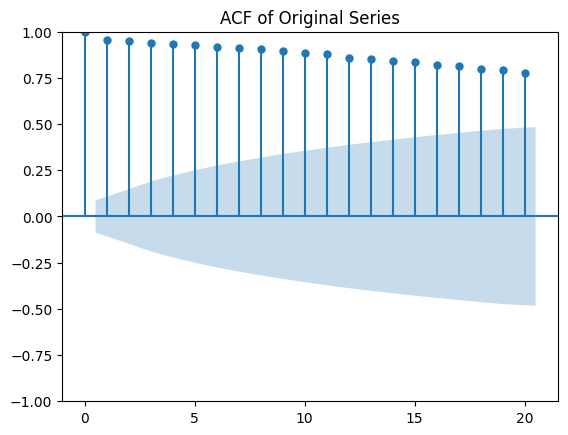

In [ ]:
# Uji ADF
adf_result = adfuller(data)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

# Plot ACF
plot_acf(data, lags=20)
plt.title("ACF of Original Series")
plt.show()

In [ ]:
#Diferensiasi semua data
data_diff = data.diff().dropna()
adf_result_datadiff = adfuller(data_diff)
print(f"ADF Statistic setelah differencing: {adf_result_datadiff[0]}")
print(f"p-value: {adf_result_datadiff[1]}")

ADF Statistic setelah differencing: -5.724810664942231
p-value: 6.80988306120483e-07


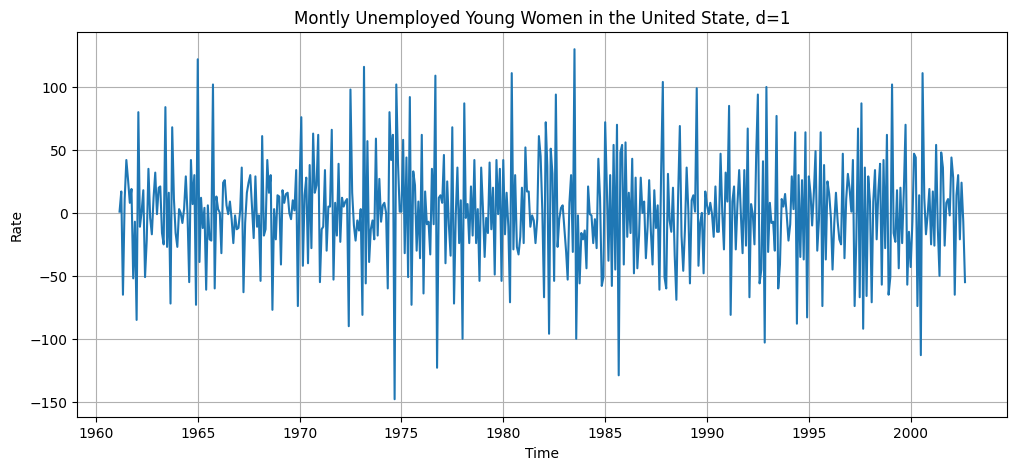

In [ ]:
# Plot data asli setelah diff
plt.figure(figsize=(12, 5))
plt.plot(data_diff)
plt.title("Montly Unemployed Young Women in the United State, d=1")
plt.xlabel("Time")
plt.ylabel("Rate")
plt.grid(True)
plt.show()

Panjang data training: 400
Panjang data testing: 100


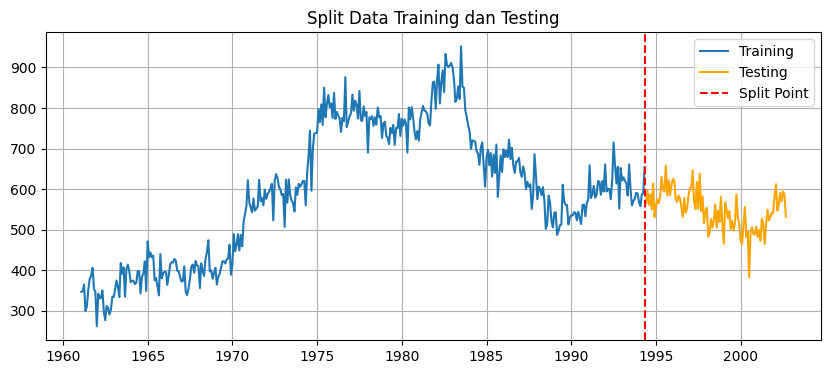

In [ ]:
#Spliting data
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

print(f"Panjang data training: {len(train)}")
print(f"Panjang data testing: {len(test)}")

# Visualisasi split
plt.figure(figsize=(10, 4))
plt.plot(train, label="Training")
plt.plot(test, label="Testing", color='orange')
plt.axvline(x=train.index[-1], color='red', linestyle='--', label='Split Point')
plt.title("Split Data Training dan Testing")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Uji ADF
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(train)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

#Jika p-value > 0.05, maka data tidak stasioner dan perlu diferensiasi.

ADF Statistic: -1.9337768623799487
p-value: 0.3163419859712469


In [ ]:
#Diferensiasi
train_diff = train.diff().dropna()
adf_result_diff = adfuller(train_diff)
print(f"ADF Statistic setelah differencing: {adf_result_diff[0]}")
print(f"p-value: {adf_result_diff[1]}")

ADF Statistic setelah differencing: -4.700081477822964
p-value: 8.412312502971929e-05


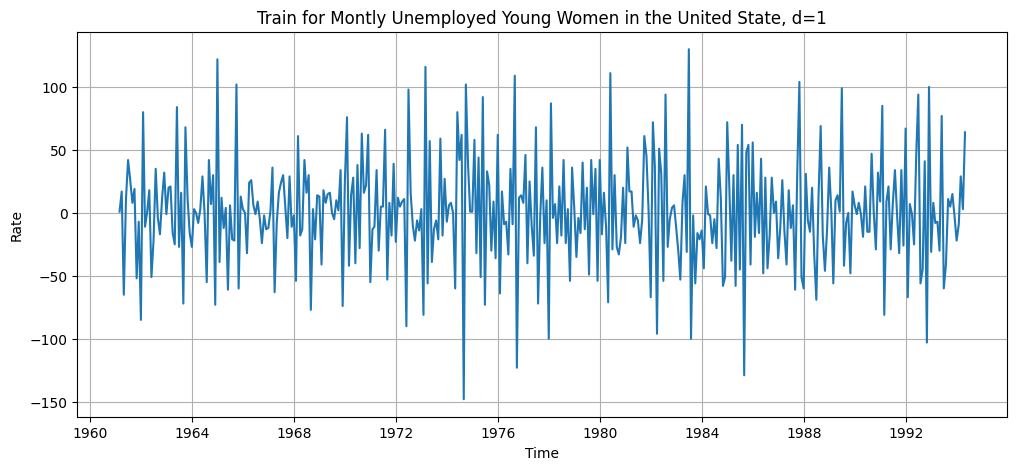

In [ ]:
# Plot data train setelah diff
plt.figure(figsize=(12, 5))
plt.plot(train_diff)
plt.title("Train for Montly Unemployed Young Women in the United State, d=1")
plt.xlabel("Time")
plt.ylabel("Rate")
plt.grid(True)
plt.show()

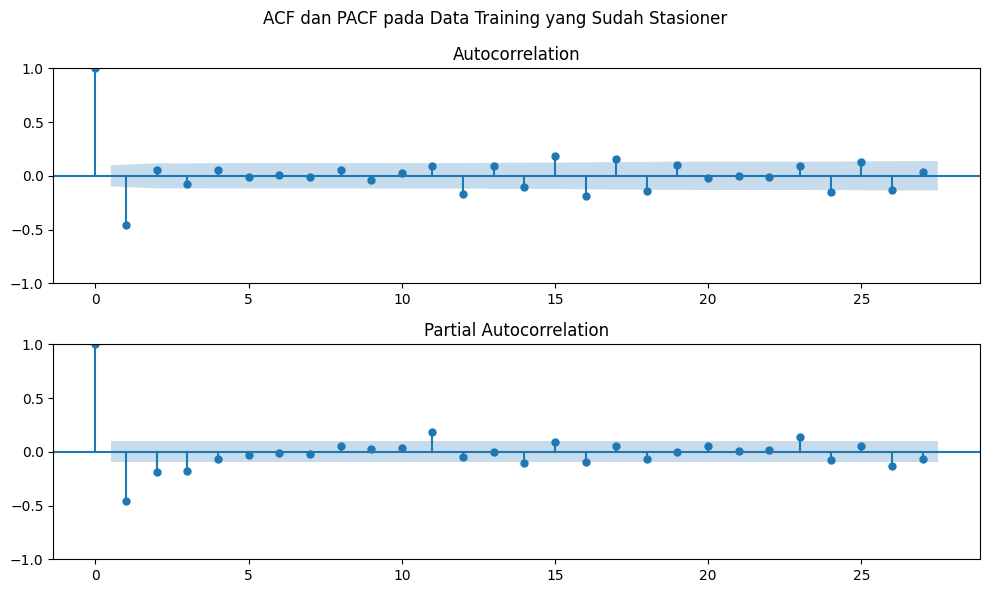

In [ ]:
#Plot ACF dan PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(train_diff, ax=ax[0])
plot_pacf(train_diff, ax=ax[1])
plt.suptitle("ACF dan PACF pada Data Training yang Sudah Stasioner")
plt.tight_layout()
plt.show()


     0         1         2         3         4         5
0  1.0  0.954647  0.949657  0.939847  0.934544  0.926468
1  1.0 -0.439765  0.080517 -0.050092  0.055258  0.017568
2  1.0 -0.092557 -0.221024  -0.04523  0.019488  0.048156
3  1.0 -0.034449   -0.0956 -0.165432   0.02943  0.036533
4  1.0 -0.020036 -0.024511  -0.04315 -0.074945  0.052319
5  1.0 -0.003656 -0.002306 -0.001952 -0.007316 -0.008026


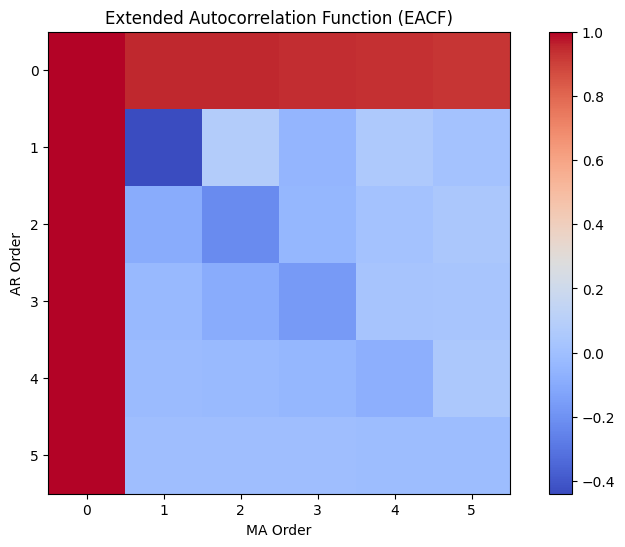

In [ ]:

# Fungsi untuk menghitung EACF
def eacf(series, max_ar=5, max_ma=5):
    """
    Menghitung Extended Autocorrelation Function (EACF)

    Parameters:
    series : array-like - data time series
    max_ar : int - order AR maksimum
    max_ma : int - order MA maksimum

    Returns:
    DataFrame yang berisi EACF
    """
    eacf_df = pd.DataFrame(index=range(max_ar+1), columns=range(max_ma+1))

    for ar_order in range(max_ar+1):
        for ma_order in range(max_ma+1):
            # Menghitung residual setelah fitting AR(ar_order)
            if ar_order == 0:
                resid = series
            else:
                from statsmodels.tsa.ar_model import AutoReg
                model = AutoReg(series, lags=ar_order)
                results = model.fit()
                resid = results.resid

            # Menghitung ACF dari residual
            acf_vals = acf(resid, nlags=ma_order, fft=False)
            eacf_df.loc[ar_order, ma_order] = acf_vals[-1] if ma_order > 0 else 1.0

    return eacf_df


# Hitung EACF
eacf_result = eacf(data, max_ar=5, max_ma=5)
print(eacf_result)

# Visualisasi (opsional)
plt.figure(figsize=(10, 6))
plt.imshow(eacf_result.astype(float), cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(eacf_result.columns)), eacf_result.columns)
plt.yticks(range(len(eacf_result.index)), eacf_result.index)
plt.xlabel('MA Order')
plt.ylabel('AR Order')
plt.title('Extended Autocorrelation Function (EACF)')
plt.show()

In [ ]:
#Estimasi Model ARIMA pada Data Training

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(0, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Un_Young_W   No. Observations:                  400
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2002.308
Date:                Mon, 19 May 2025   AIC                           4008.616
Time:                        13:51:15   BIC                           4016.594
Sample:                    01-31-1961   HQIC                          4011.775
                         - 04-30-1994                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5776      0.037    -15.672      0.000      -0.650      -0.505
sigma2      1336.3917     82.761     16.148      0.000    1174.183    1498.600
Ljung-Box (L1) (Q):                   0.21   Jarque-

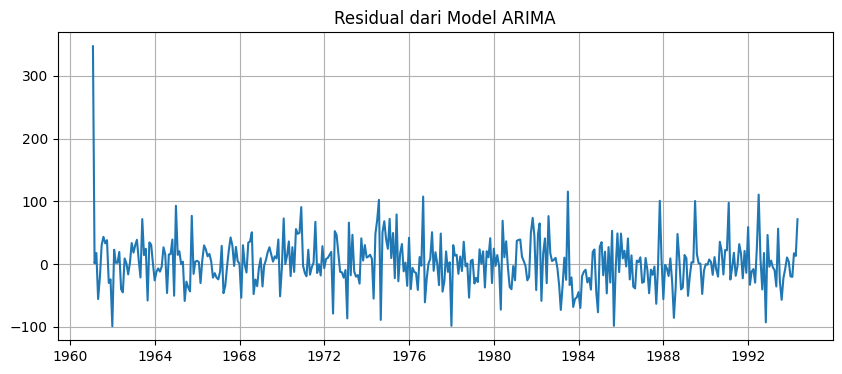

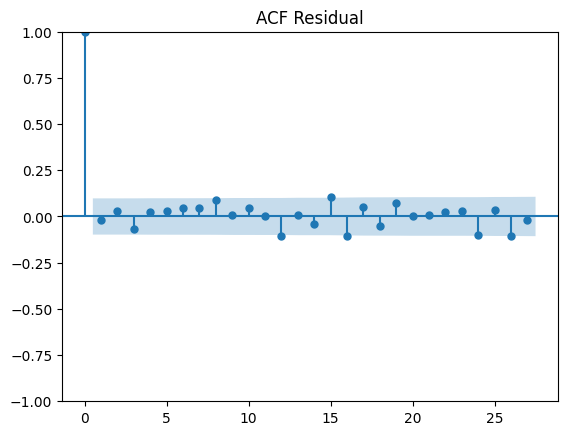

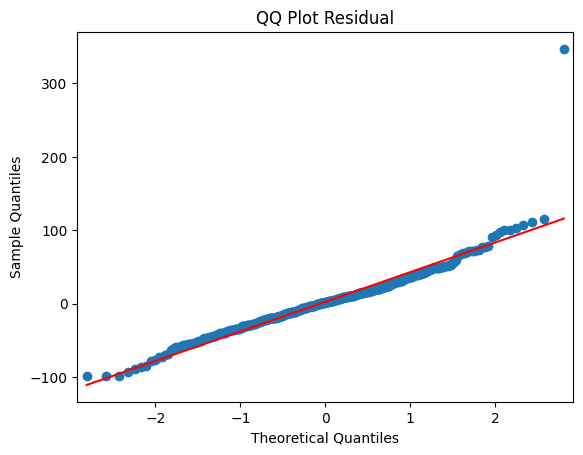

In [ ]:
# Diagnostik Model
import statsmodels.api as sm

resid = model_fit.resid
# Plot Residual
plt.figure(figsize=(10, 4))
plt.plot(resid)
plt.title("Residual dari Model ARIMA")
plt.grid(True)
plt.show()

# ACF dari residual
plot_acf(resid)
plt.title("ACF Residual")
plt.show()

# QQ Plot
sm.qqplot(resid, line='s')
plt.title("QQ Plot Residual")
plt.show()

In [ ]:
#Overfitting

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(0, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Un_Young_W   No. Observations:                  400
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -2002.109
Date:                Mon, 19 May 2025   AIC                           4010.219
Time:                        11:58:06   BIC                           4022.185
Sample:                    01-31-1961   HQIC                          4014.958
                         - 04-30-1994                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5967      0.047    -12.640      0.000      -0.689      -0.504
ma.L2          0.0291      0.053      0.550      0.582      -0.075       0.133
sigma2      1335.0450     82.630     16.157      0.0

In [ ]:
#Overfitting

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Un_Young_W   No. Observations:                  400
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2002.100
Date:                Mon, 19 May 2025   AIC                           4010.200
Time:                        11:58:28   BIC                           4022.167
Sample:                    01-31-1961   HQIC                          4014.939
                         - 04-30-1994                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0528      0.091     -0.580      0.562      -0.231       0.126
ma.L1         -0.5446      0.074     -7.403      0.000      -0.689      -0.400
sigma2      1334.9588     82.556     16.170      0.0

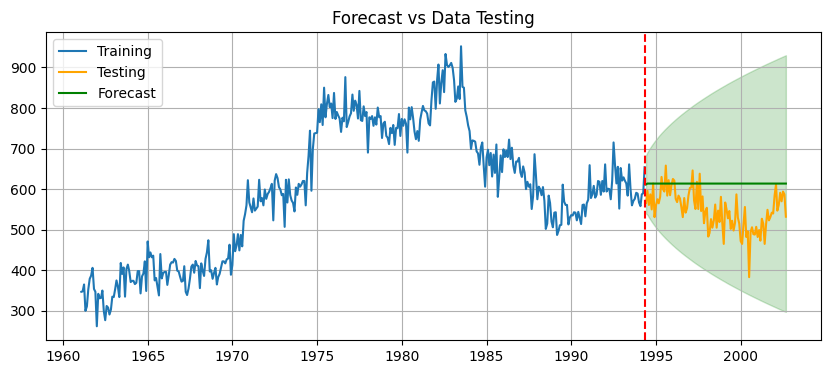

In [ ]:
# Prediksi dan Evaluasi Model pada Data Testing
# Forecast untuk panjang data test
forecast_result = model_fit.get_forecast(steps=len(test))
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# Plot
plt.figure(figsize=(10, 4))
plt.plot(train, label='Training')
plt.plot(test.index, test, label='Testing', color='orange')
plt.plot(test.index, forecast_mean, label='Forecast', color='green')
plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],
                 color='green', alpha=0.2)
plt.axvline(x=train.index[-1], color='red', linestyle='--')
plt.title("Forecast vs Data Testing")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluasi akurasi model
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test, forecast_mean)
mae = mean_absolute_error(test, forecast_mean)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Hitung MAPE antara data testing dan hasil prediksi
mape = mean_absolute_percentage_error(test, forecast_mean)
print(f"MAPE: {mape:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")

MAPE: 13.19%
MSE: 6471.29
MAE: 68.00
